<a href="https://www.kaggle.com/code/mikedelong/python-eda-with-scatterplot?scriptVersionId=142153189" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

I do not know this Fort Night of which you speak. Is it the one with the dancing?

In [1]:
import pandas as pd
df = pd.read_csv('/kaggle/input/fortnite-statistics/Fortnite Statistics.csv')
# we want our accuracy as an int or float
df['Accuracy (pct)'] = df['Accuracy'].apply(func=lambda x: int(x.replace('%', '')))
# we can treat time of day as an evening hour without loss of generality
df['hour'] = df['Time of Day'].apply(func=lambda x: 12 + int(x.split(':')[0]))
df['day'] = df['Date'].apply(func=lambda x: int(x.replace('4/', '').replace('-Apr', '')))
df['sober'] = df['Mental State'] == 'sober'
# lower-case placed is upper-case Placed but with higher values for higher ranked placces
df['placed'] = df['Placed'].max() - df['Placed']
df.head()

,Date,Time of Day,Placed,Mental State,Eliminations,Assists,Revives,Accuracy,Hits,Head Shots,...,Materials Gathered,Materials Used,Damage Taken,Damage to Players,Damage to Structures,Accuracy (pct),hour,day,sober,placed
0,4/10,6:00 PM,27,sober,2,0,0,23%,14,2,...,20,20,272,331,621,23,18,10,True,39
1,4/10,6:00 PM,45,sober,1,2,0,30%,19,1,...,123,30,247,444,998,30,18,10,True,21
2,4/10,6:00 PM,38,high,3,0,0,30%,32,1,...,71,60,176,322,1109,30,18,10,False,28
3,4/10,7:00 PM,30,high,1,3,0,18%,19,1,...,244,10,238,330,4726,18,19,10,False,36
4,4/10,7:00 PM,16,high,3,1,1,58%,42,18,...,584,150,365,668,2070,58,19,10,False,50


In [2]:
df['Date'].value_counts()

Date
4/14      24
4/13      17
4/10      14
4/15      13
4/11      12
17-Apr     5
16-Apr     2
Name: count, dtype: int64

In [3]:
df['Placed'].max()

66

In [4]:
df['sober'].value_counts()

sober
True     45
False    42
Name: count, dtype: int64

In [5]:
df.shape

(87, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  87 non-null     object 
 1   Time of Day           87 non-null     object 
 2   Placed                87 non-null     int64  
 3   Mental State          87 non-null     object 
 4   Eliminations          87 non-null     int64  
 5   Assists               87 non-null     int64  
 6   Revives               87 non-null     int64  
 7   Accuracy              87 non-null     object 
 8   Hits                  87 non-null     int64  
 9   Head Shots            87 non-null     int64  
 10  Distance Traveled     87 non-null     float64
 11  Materials Gathered    87 non-null     int64  
 12  Materials Used        87 non-null     int64  
 13  Damage Taken          87 non-null     int64  
 14  Damage to Players     87 non-null     int64  
 15  Damage to Structures  87 

In [7]:
df.nunique()

Date                     7
Time of Day             13
Placed                  41
Mental State             2
Eliminations             9
Assists                  7
Revives                  5
Accuracy                38
Hits                    52
Head Shots              19
Distance Traveled       85
Materials Gathered      77
Materials Used          30
Damage Taken            74
Damage to Players       84
Damage to Structures    85
Accuracy (pct)          38
hour                    12
day                      7
sober                    2
placed                  41
dtype: int64

In [8]:
from plotly.express import scatter
scatter(data_frame=df, x='Distance Traveled', y='Damage to Players', color='Mental State', size='placed',)

Will TSNE find sober clusters all by itself? (probably not)

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=2023, verbose=1)
tsne_result = tsne.fit_transform(X=df.drop(columns=['Date', 'Time of Day', 'Mental State', 'Accuracy', 'sober']))
tsne_df = df[['Date', 'Time of Day', 'sober', 'placed']].copy()
tsne_df['x'] = tsne_result[:, 0]
tsne_df['y'] = tsne_result[:, 1]

[t-SNE] Computing 86 nearest neighbors...
[t-SNE] Indexed 87 samples in 0.001s...
[t-SNE] Computed neighbors for 87 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 87 / 87
[t-SNE] Mean sigma: 767.490106
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.838600
[t-SNE] KL divergence after 950 iterations: 0.058606


In [10]:
scatter(data_frame=tsne_df, x='x', y='y', color='sober', hover_data=['Date', 'Time of Day',], size='placed')

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Mental State', 'Accuracy', 'sober']), 
                                                    df['sober'].astype(int), test_size=0.5, random_state=2023,
                                                   stratify=df['sober'].values)
print('stratify train: {:6.3f} test: {:6.3f}'.format(y_train.sum()/len(y_train), y_test.sum()/len(y_test)))

stratify train:  0.512 test:  0.523


In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
bayes = GaussianNB(priors=None, var_smoothing=1e-4)
bayes.fit(X=X_train.drop(columns=['Date', 'Time of Day']), y=y_train)
print(classification_report(y_true=y_test, y_pred=bayes.predict(X=X_test.drop(columns=['Date', 'Time of Day']))))

              precision    recall  f1-score   support

           0       0.62      0.38      0.47        21
           1       0.58      0.78      0.67        23

    accuracy                           0.59        44
   macro avg       0.60      0.58      0.57        44
weighted avg       0.60      0.59      0.57        44



Are we doing better than a model that always guesses the majority class?

In [13]:
from numpy import ones
print(classification_report(y_true=y_test, y_pred=ones(shape=len(y_test)), zero_division=0,))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.52      1.00      0.69        23

    accuracy                           0.52        44
   macro avg       0.26      0.50      0.34        44
weighted avg       0.27      0.52      0.36        44



We are mostly guessing.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



0:01:25.910490


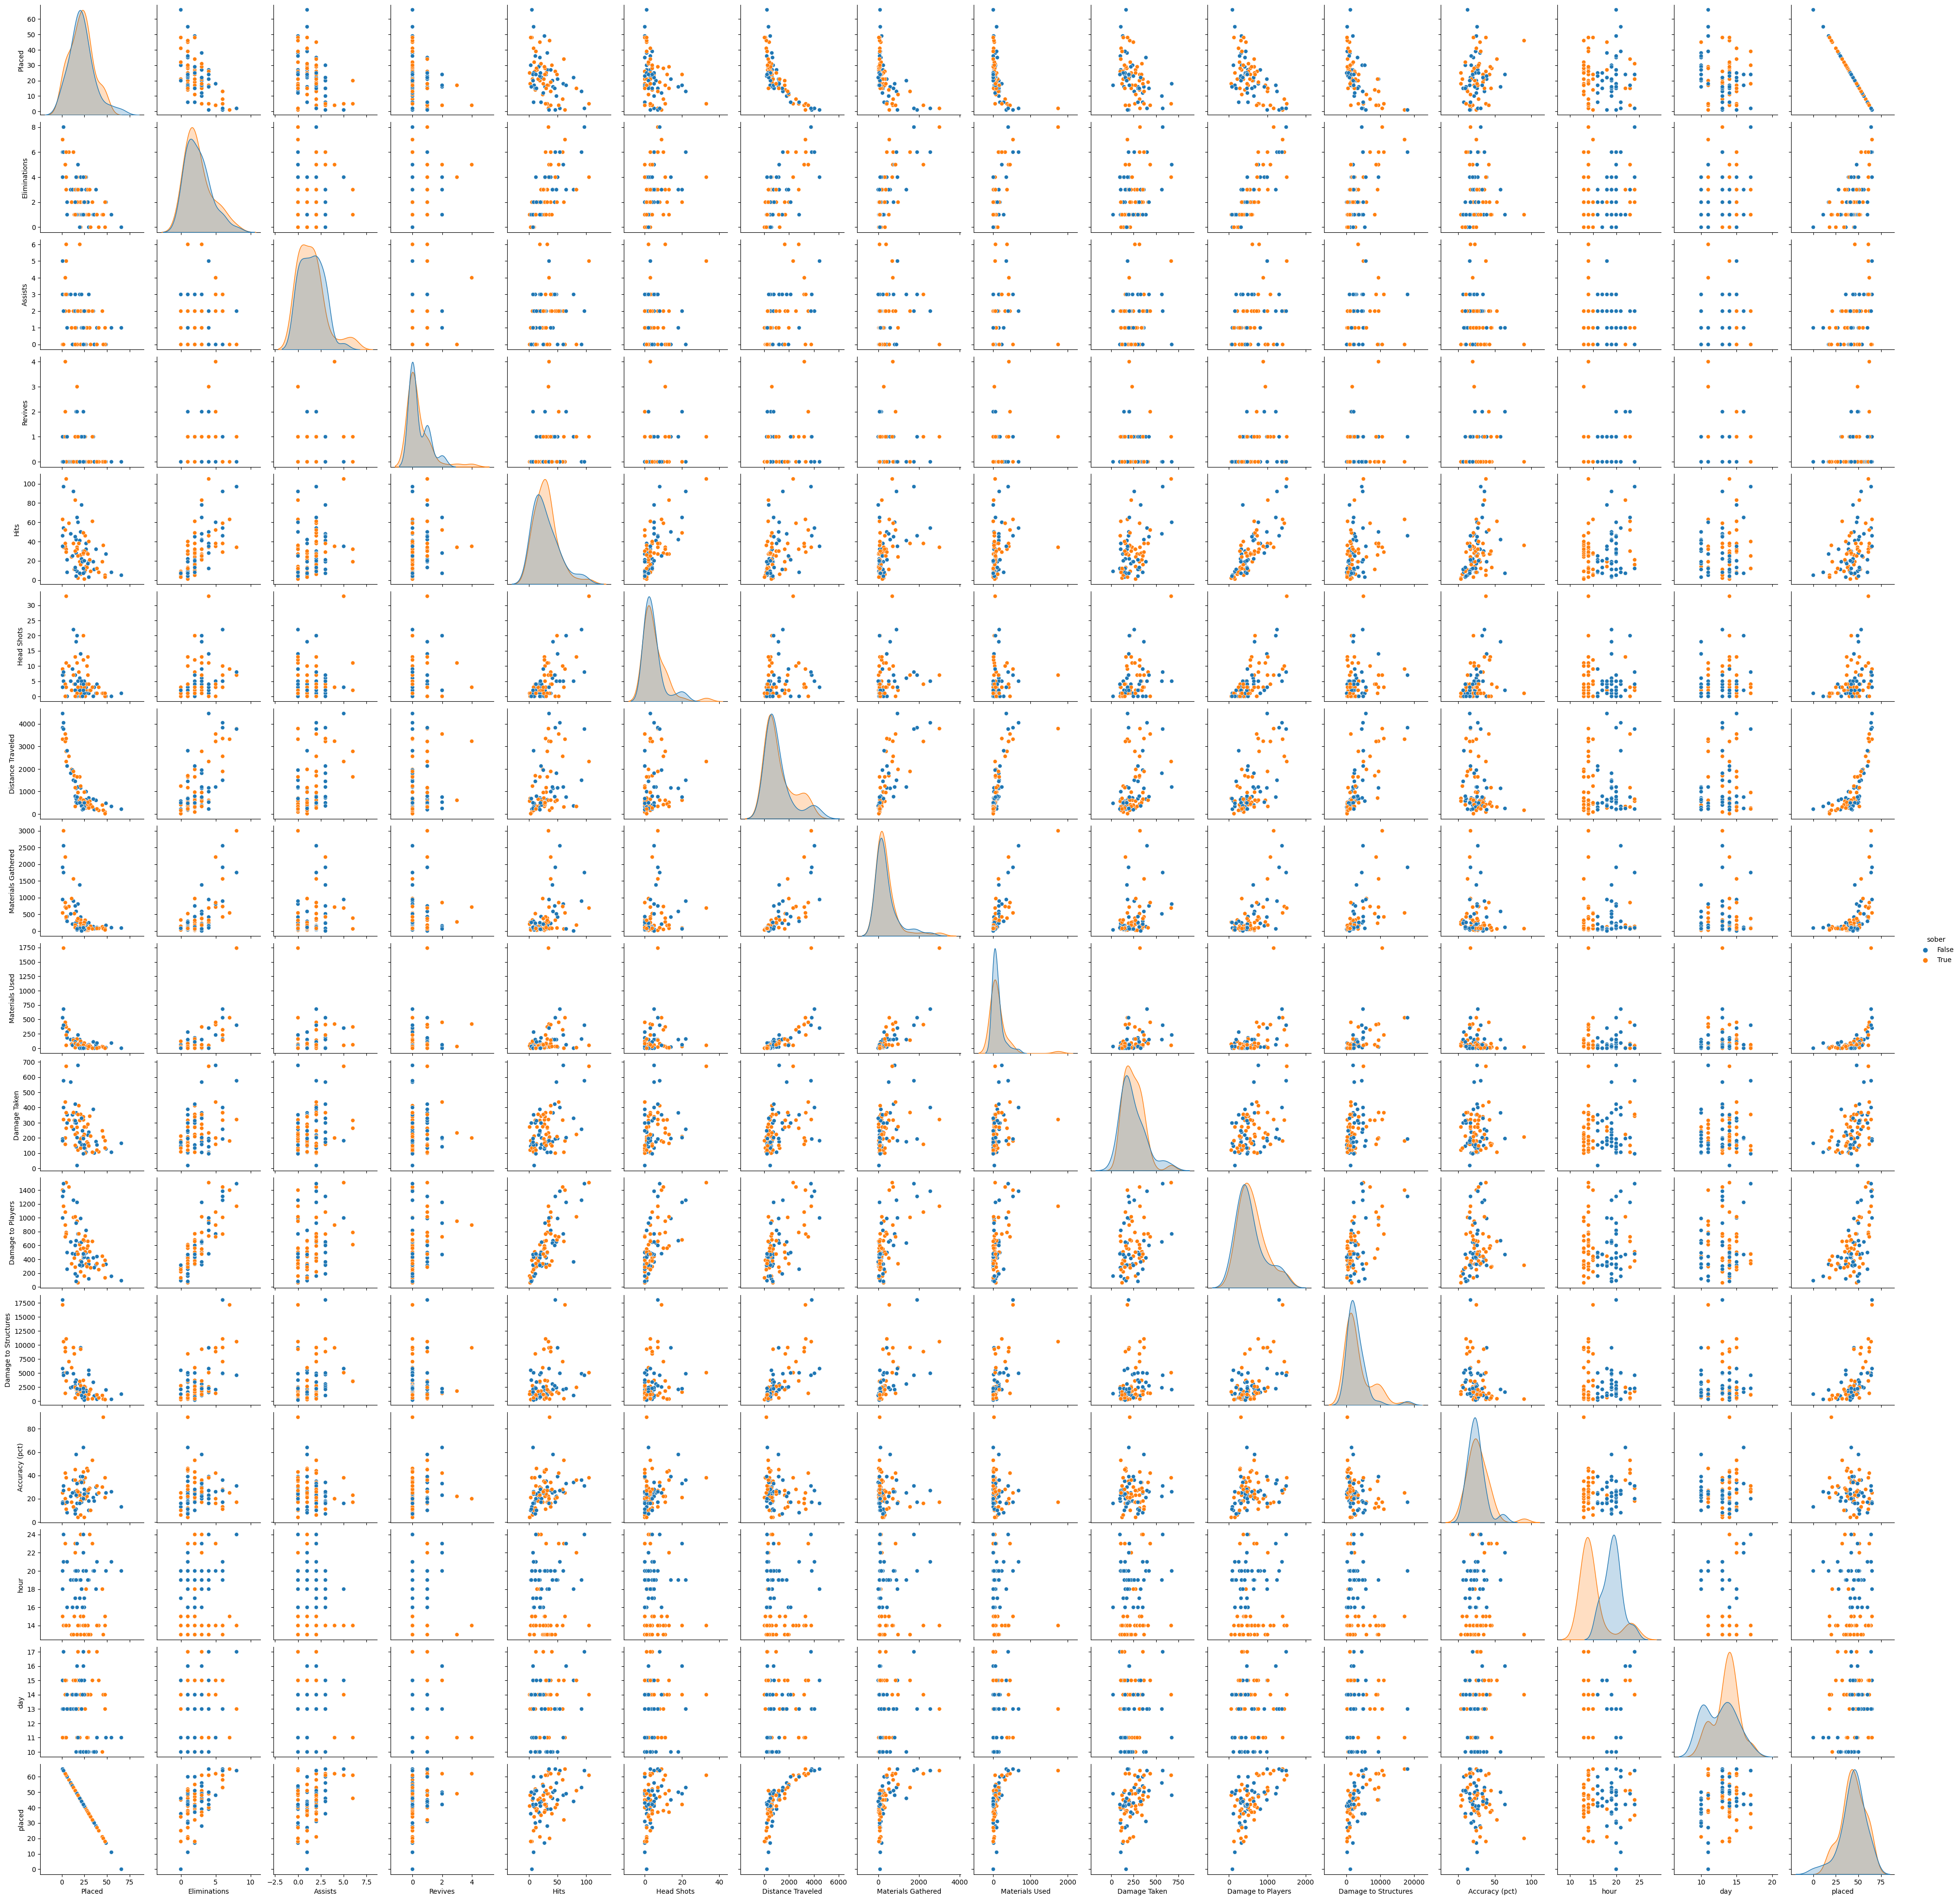

In [14]:
# this takes forever but it's worth the wait
from seaborn import pairplot
from arrow import now
time_pairplot = now()
pairplot(data=df, hue='sober')
print(now() - time_pairplot)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



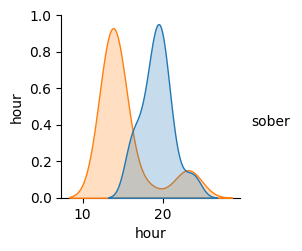

In [15]:
pairplot(data=df[['hour', 'sober']], hue='sober')

<Axes: xlabel='Date', ylabel='hour'>

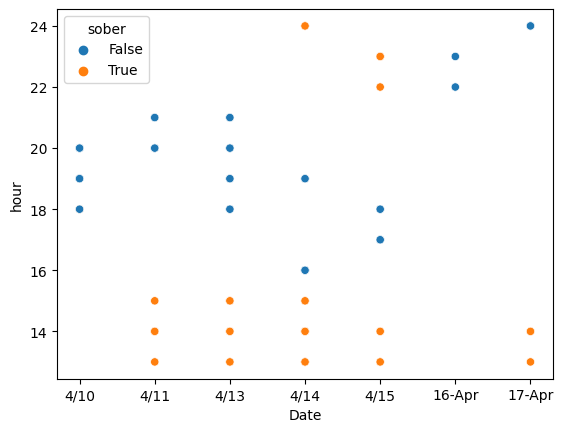

In [16]:
from seaborn import scatterplot
scatterplot(data=df, x='Date', y='hour', hue='sober')

In [17]:
small_bayes = GaussianNB(priors=None, var_smoothing=1e-4)
small_bayes.fit(X=X_train[['day', 'hour']], y=y_train)
print(classification_report(y_true=y_test, y_pred=small_bayes.predict(X=X_test[['day', 'hour']])))

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        21
           1       0.75      0.91      0.82        23

    accuracy                           0.80        44
   macro avg       0.81      0.79      0.79        44
weighted avg       0.81      0.80      0.79        44



Basically we can predict state of mind much better by ignoring the game performance data.

Obviously the variable we want to predict is placement.

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
drop_columns = ['Mental State', 'Accuracy', 'Date', 'Time of Day', 'Placed', 'placed']
XR_train, XR_test, yR_train, yR_test = train_test_split(df.drop(columns=drop_columns), df['placed'], test_size=0.5, random_state=2023,)
regressor = RandomForestRegressor(n_estimators=10, random_state=2023, verbose=1)
regressor.fit(X=XR_train, y=yR_train)
yR_pred = regressor.predict(X=XR_test)
print('r2 score: {:6.3f}'.format(r2_score(y_true=yR_test, y_pred=yR_pred)))
print('mea: {:6.3f}'.format(mean_absolute_error(y_true=yR_test, y_pred=yR_pred)))

r2 score:  0.421
mea:  6.220


<Axes: xlabel='true', ylabel='pred'>

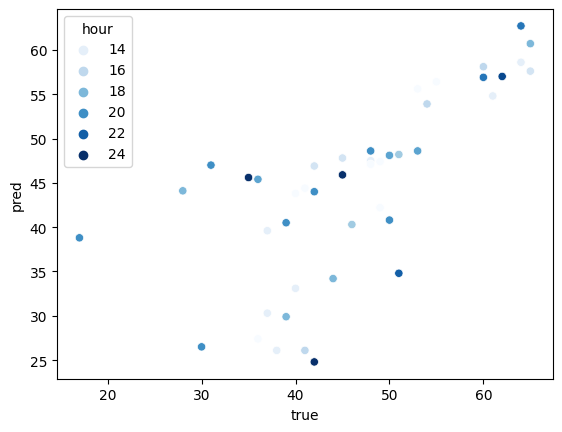

In [19]:
regressor_df = pd.DataFrame(data={'true': yR_test, 'pred': yR_pred, 'sober': XR_test['sober'], 'hour': XR_test['hour']})
scatterplot(data=regressor_df.sort_values(by='true'), x='true', y='pred', hue='hour', palette='Blues')

Basically the model does better for higher placements (where placed is larger) but for lower placements not so much. I suppose this isn't surprising, is it?